<h1> Modelagem e implementação do algoritmo

<h3>Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

<h3>Carregando os dados provenientes do TCC do Vinicius

In [2]:
data_path = '..\data\dados_trajeto.csv'

In [3]:
df = pd.read_csv(data_path, sep = ';')

In [4]:
df.head()

,tempo_s,distancia_m
0,10,155.42
1,11,167.37
2,12,179.33
3,13,191.28
4,14,203.24


In [5]:
df['tempo_s'] = df['tempo_s'] - 10
df['distancia_m'] = df['distancia_m'] - 155.42

df.head()

,tempo_s,distancia_m
0,0,0.00
1,1,11.95
2,2,23.91
3,3,35.86
4,4,47.82


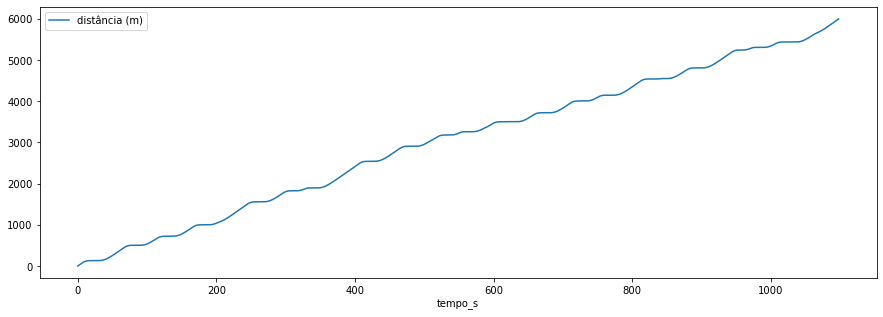

In [6]:
temp = pd.Series(data=df['distancia_m'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="distância (m)", legend=True)

plt.show()

In [7]:
delta = df.diff()
delta

,tempo_s,distancia_m
0,NaN,NaN
1,1.0,11.95
2,1.0,11.96
3,1.0,11.95
4,1.0,11.96
...,...,...
1094,1.0,11.87
1095,1.0,11.89
1096,1.0,11.89
1097,1.0,11.91


In [8]:
df['velocidade'] = delta['distancia_m']/delta['tempo_s']

In [9]:
df.fillna(0, inplace=True)
df.head()

,tempo_s,distancia_m,velocidade
0,0,0.00,0.00
1,1,11.95,11.95
2,2,23.91,11.96
3,3,35.86,11.95
4,4,47.82,11.96


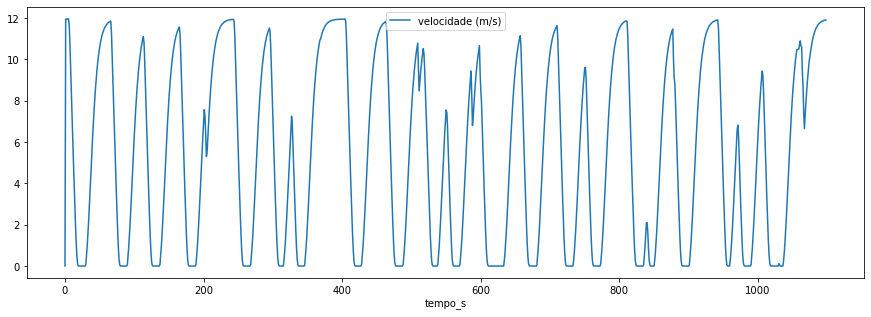

In [10]:
temp = pd.Series(data=df['velocidade'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="velocidade (m/s)", legend=True)

plt.show()

<h3>Modelando a demanda de potência do veículo

**Força de arrasto (Fa)**

Fa(t) = 0,5.ρ.Cd.Af.(v(t))²

em que:
* ρ é a densidade do ar
* Cd é o coeficiente de arrasto para o ônibus
* Af é a área da superfície frontal do veículo
* v(t) é a velocidade do veículo em função do tempo


*(Para fins de facilitar os cálculos nesta primeira fase de implementação, será considerado uma inclinação de **0 graus** no trajeto)*

**Força de resistência ao rolamento (Fr)**

Fr(t) = m.g.Cr.cos(§(t))

em que:
* m é a massa do veículo
* g é a aceleração da gravidade (9,81 m/s²)
* Cr é o coeficiente de atrito de rolamento
* §(t) é a inclinação do trajeto em função do tempo

**Força gravitacional (Fg)**

Fg(t) = m.g.Cr.sin(§(t))
(Será nula uma vez que foi considerado um angulo de inclinação de 0 graus)

**Força de aceleração (Facc)**

Facc(t) = m.(dvc(t)/dt)


A Força de tração é a soma de todas as forças citadas acima:

Ftr(t) = Facc(t) + Fg(t) + Fr(t) + Fa(t)

Assim, a demanda de potência pode ser dada por:

Ptr(t) = Ftr(t).v(t)

#### Parâmetros:
    
Cd = 0,36 -> Modelo de ônibus com os cantos da face arredondados Hucho (1986) <br>
ρ = 1,2754 kg/m³ <br>
Fr = 0,9 -> [fonte](https://www.if.ufrgs.br/~lang/Textos/Pneus.pdf) <br>
Af = 2,4x,2,7 = 6,48m² -> [fonte](https://www.ehow.com.br/tamanho-padrao-onibus-urbano-fatos_71396/) <br>
m = 12000 kg -> peso média de um ônibus médio -> [fonte](https://www.diariodasleis.com.br/legislacao/federal/61150-aprova-as-especificacoes-tecnicas-de-veiculos-automotores-de-transporte-coletivo-de-passageiros-rodoviario-e-urbano-intermunicipal.html#:~:text=%C3%94nibus%20leve%3A%20aquele%20com%20peso,ou%20superior%20a%2014%2C0t.) <br>

In [11]:
delta = df.diff()
df['acc'] = abs(delta['velocidade'])/delta['tempo_s']
df.fillna(0, inplace=True)
df.head()

,tempo_s,distancia_m,velocidade,acc
0,0,0.00,0.00,0.00
1,1,11.95,11.95,11.95
2,2,23.91,11.96,0.01
3,3,35.86,11.95,0.01
4,4,47.82,11.96,0.01


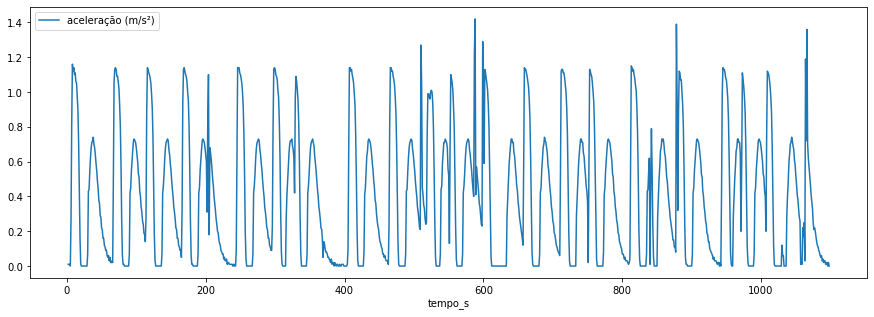

In [12]:
temp = pd.Series(data=df['acc'][2:].values, 
                 index=df['tempo_s'][2:])

temp.plot(figsize=(15, 5), label="aceleração (m/s²)", legend=True)

plt.show()

In [13]:
m = 12000
rho = 1.2754
Cd = 0.36
Cr = 0.9
Af = 6.48
g = 9.81

In [14]:
df['Fa'] = 0.5*rho*Cd*Af*((df['velocidade'])**2)
df['Fr'] = m*g*Cr
df['Facc'] = m*df['acc']
df['Ftr'] = df['Fa'] + df['Fr'] + df['Facc']
df['pot'] = (df['Ftr']*df['velocidade'])/1000

In [15]:
df

,tempo_s,distancia_m,velocidade,acc,Fa,Fr,Facc,Ftr,pot
0,0,0.00,0.00,0.000000e+00,0.000000,105948.0,0.000000e+00,105948.000000,0.000000e+00
1,1,11.95,11.95,1.195000e+01,212.436792,105948.0,1.434000e+05,249560.436792,2.982247e+06
2,2,23.91,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1.271118e+06
3,3,35.86,11.95,1.000000e-02,212.436792,105948.0,1.200000e+02,106280.436792,1.270051e+06
4,4,47.82,11.96,1.000000e-02,212.792483,105948.0,1.200000e+02,106280.792483,1.271118e+06
...,...,...,...,...,...,...,...,...,...
1094,1094,5946.14,11.87,1.000000e-02,209.601971,105948.0,1.200000e+02,106277.601971,1.261515e+06
1095,1095,5958.03,11.89,2.000000e-02,210.308891,105948.0,2.400000e+02,106398.308891,1.265076e+06
1096,1096,5969.92,11.89,9.094947e-13,210.308891,105948.0,1.091394e-08,106158.308891,1.262222e+06
1097,1097,5981.83,11.91,2.000000e-02,211.017001,105948.0,2.400000e+02,106399.017001,1.267212e+06


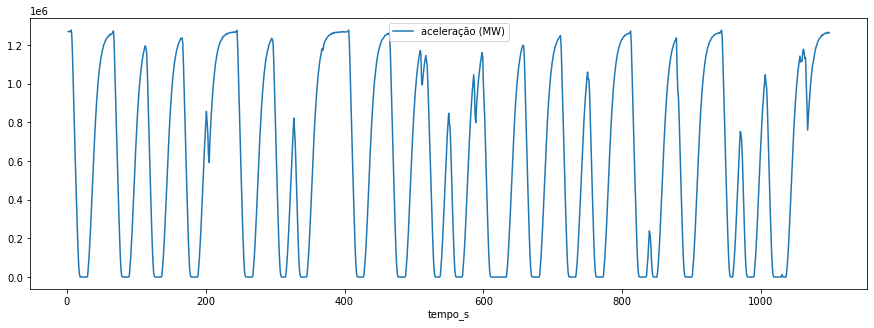

In [16]:
temp = pd.Series(data=df['pot'][2:].values, 
                 index=df['tempo_s'][2:])

temp.plot(figsize=(15, 5), label="Demanda de potência (MW)", legend=True)

plt.show()